In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Week 6: Neural Network Implementation

**Student:** Naman Nagar  
**SRN:** PES2UG23CS361

This notebook implements a neural network from scratch using NumPy to learn a student-specific polynomial function.

In [2]:
STUDENT_ID = "PES1UG23CS999"

## Student Configuration

In [3]:
def get_student_assignment(student_id):
    """
    Generate unique polynomial TYPE and architecture based on student ID
    Uses last 3 digits of student ID for assignment
    """

    last_three = int(student_id[-3:])

    poly_type = last_three % 5

    np.random.seed(last_three)

    if poly_type == 0:
        degree = 2
        a = 0
        b = np.random.uniform(0.8, 1.5)
        c = np.random.uniform(3.0, 8.0)
        d = np.random.uniform(5.0, 15.0)
        poly_desc = f"QUADRATIC: y = {b:.2f}x² + {c:.2f}x + {d:.2f}"

    elif poly_type == 1:
        degree = 3
        a = np.random.uniform(1.8, 2.5)
        b = np.random.uniform(-1.2, 0.2)
        c = np.random.uniform(3.0, 6.0)
        d = np.random.uniform(8.0, 12.0)
        poly_desc = f"CUBIC: y = {a:.2f}x³ + {b:.2f}x² + {c:.2f}x + {d:.2f}"

    elif poly_type == 2:
        degree = 4
        a = np.random.uniform(0.008, 0.02)
        b = np.random.uniform(1.5, 2.2)
        c = np.random.uniform(-1.0, 0.5)
        d = np.random.uniform(2.0, 5.0)
        e = np.random.uniform(8.0, 12.0)
        poly_desc = f"QUARTIC: y = {a:.4f}x⁴ + {b:.2f}x³ + {c:.2f}x² + {d:.2f}x + {e:.2f}"
        coefficients = (a, b, c, d, e)

    elif poly_type == 3:
        degree = "sine"
        a = np.random.uniform(1.5, 2.8)
        b = np.random.uniform(-0.8, 0.8)
        c = np.random.uniform(3.0, 6.0)
        d = np.random.uniform(8.0, 12.0)
        freq = np.random.uniform(0.02, 0.05)
        amp = np.random.uniform(5.0, 15.0)
        poly_desc = f"CUBIC + SINE: y = {a:.2f}x³ + {b:.2f}x² + {c:.2f}x + {d:.2f} + {amp:.1f}*sin({freq:.3f}x)"
        coefficients = (a, b, c, d, freq, amp)

    else:
        degree = "inverse"
        a = np.random.uniform(1.8, 2.5)
        b = np.random.uniform(-1.0, 0.5)
        c = np.random.uniform(3.0, 6.0)
        d = np.random.uniform(8.0, 12.0)
        inv_coeff = np.random.uniform(50, 200)
        poly_desc = f"CUBIC + INVERSE: y = {a:.2f}x³ + {b:.2f}x² + {c:.2f}x + {d:.2f} + {inv_coeff:.1f}/x"
        coefficients = (a, b, c, d, inv_coeff)


    if poly_type in [0, 1]:
        coefficients = (a, b, c, d)


    noise_std = np.random.uniform(1.5, 2.5)


    arch_type = last_three % 4
    architectures = {
        0: {"hidden1": 64, "hidden2": 64, "lr": 0.001, "batch_desc": "Balanced Architecture"},
        1: {"hidden1": 32, "hidden2": 72, "lr": 0.005, "batch_desc": "Narrow-to-Wide Architecture"},
        2: {"hidden1": 72, "hidden2": 32, "lr": 0.001, "batch_desc": "Wide-to-Narrow Architecture"},
        3: {"hidden1": 96, "hidden2": 96, "lr": 0.003, "batch_desc": "Large Balanced Architecture"}
    }

    return {
        "polynomial_type": poly_type,
        "degree": degree,
        "coefficients": coefficients,
        "polynomial_desc": poly_desc,
        "noise_std": noise_std,
        "architecture": architectures[arch_type],
        "student_seed": last_three
    }

# Get your assignment
assignment = get_student_assignment(STUDENT_ID)
poly_type = assignment["polynomial_type"]
degree = assignment["degree"]
coefficients = assignment["coefficients"]
noise_std = assignment["noise_std"]
hidden1 = assignment["architecture"]["hidden1"]
hidden2 = assignment["architecture"]["hidden2"]
learning_rate = assignment["architecture"]["lr"]

print("="*70)
print(f"ASSIGNMENT FOR STUDENT ID: {STUDENT_ID}")
print("="*70)
print(f"Polynomial Type: {assignment['polynomial_desc']}")
print(f"Noise Level: ε ~ N(0, {noise_std:.2f})")
print(f"Architecture: Input(1) → Hidden({hidden1}) → Hidden({hidden2}) → Output(1)")
print(f"Learning Rate: {learning_rate}")
print(f"Architecture Type: {assignment['architecture']['batch_desc']}")
print("="*70)


ASSIGNMENT FOR STUDENT ID: PES1UG23CS999
Polynomial Type: CUBIC + INVERSE: y = 2.36x³ + -0.21x² + 3.36x + 10.56 + 63.6/x
Noise Level: ε ~ N(0, 1.83)
Architecture: Input(1) → Hidden(96) → Hidden(96) → Output(1)
Learning Rate: 0.003
Architecture Type: Large Balanced Architecture


## Dataset Generation and Preprocessing

In [4]:
np.random.seed(assignment["student_seed"])

n_samples = 100000
x = np.random.uniform(-100, 100, n_samples)


if poly_type == 0:
    _, b, c, d = coefficients
    y = b * x**2 + c * x + d + np.random.normal(0, noise_std, n_samples)

elif poly_type == 1:
    a, b, c, d = coefficients
    y = a * x**3 + b * x**2 + c * x + d + np.random.normal(0, noise_std, n_samples)

elif poly_type == 2:
    a, b, c, d, e = coefficients
    y = a * x**4 + b * x**3 + c * x**2 + d * x + e + np.random.normal(0, noise_std, n_samples)

elif poly_type == 3:
    a, b, c, d, freq, amp = coefficients
    y = a * x**3 + b * x**2 + c * x + d + amp * np.sin(freq * x) + np.random.normal(0, noise_std, n_samples)

else:
    a, b, c, d, inv_coeff = coefficients

    y = a * x**3 + b * x**2 + c * x + d + inv_coeff / (x + np.sign(x) * 0.1) + np.random.normal(0, noise_std, n_samples)


df = pd.DataFrame({'x': x, 'y': y})
df.to_csv('student_polynomial_dataset.csv', index=False)
print(f"Dataset with {n_samples:,} samples generated and saved!")

X = df['x'].values.reshape(-1, 1)
Y = df['y'].values.reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

print(f"Training samples: {len(X_train_scaled):,}")
print(f"Test samples: {len(X_test_scaled):,}")

Dataset with 100,000 samples generated and saved!
Training samples: 80,000
Test samples: 20,000


## Activation Functions

In [ ]:
def relu(z):
    """
    ReLU activation function - I chose this because it's simple and avoids vanishing gradients
    Basically just clips negative values to zero: max(0, z)
    
    Args:
        z: input array or scalar
    Returns:
        ReLU(z) = max(0, z) element-wise
    """
    # This was surprisingly straightforward to implement
    return np.maximum(0, z)

def relu_derivative(z):
    """
    Derivative of ReLU - needed for backpropagation
    The slope is 1 for positive values, 0 for negative values
    
    Args:
        z: input array or scalar  
    Returns:
        1 if z > 0, 0 otherwise
    """
    # Converting boolean to float - neat NumPy trick I learned
    return (z > 0).astype(float)

## Loss Function

In [ ]:
def mse_loss(y_true, y_pred):
    """
    Mean Squared Error loss function - perfect for regression problems like mine
    
    I'm using this because it penalizes larger errors more heavily than smaller ones,
    which helps the network focus on reducing the biggest mistakes first.
    
    Args:
        y_true: actual target values from my dataset
        y_pred: what my network thinks the values should be
    Returns:
        MSE = mean((y_true - y_pred)^2)
    """
    # Simple but effective - square the differences and take the mean
    return np.mean((y_true - y_pred)**2)

## Weight Initialization

In [ ]:
def xavier_initialization(input_dim, hidden1, hidden2, output_dim):
    """
    Xavier weight initialization - this took me a while to get right!
    
    I learned the hard way that random initialization really matters. My first attempts 
    with simple random weights led to either exploding or vanishing gradients.
    Xavier initialization fixes this by scaling weights based on layer sizes.

    Formula: weights ~ N(0, sqrt(2/(fan_in + fan_out)))
    
    Args:
        input_dim: Size of input layer (1 in my case)
        hidden1: Size of first hidden layer
        hidden2: Size of second hidden layer  
        output_dim: Size of output layer (1)

    Returns:
        W1, b1, W2, b2, W3, b3: Properly initialized weights and biases
    """
    np.random.seed(assignment["student_seed"])

    # Calculate Xavier standard deviation for each layer
    # The magic formula that prevents gradient problems
    
    # W1: input to first hidden layer
    xavier_std_1 = np.sqrt(2 / (input_dim + hidden1))
    W1 = np.random.normal(0, xavier_std_1, (input_dim, hidden1))
    b1 = np.zeros((1, hidden1))  # Start biases at zero - standard practice

    # W2: first hidden to second hidden layer  
    xavier_std_2 = np.sqrt(2 / (hidden1 + hidden2))
    W2 = np.random.normal(0, xavier_std_2, (hidden1, hidden2))
    b2 = np.zeros((1, hidden2))

    # W3: second hidden to output layer
    xavier_std_3 = np.sqrt(2 / (hidden2 + output_dim))
    W3 = np.random.normal(0, xavier_std_3, (hidden2, output_dim))
    b3 = np.zeros((1, output_dim))

    return W1, b1, W2, b2, W3, b3

## Forward Propagation

In [ ]:
def forward_pass(X, W1, b1, W2, b2, W3, b3):
    """
    Forward propagation through my neural network
    
    This is where the magic happens! Data flows from input through hidden layers to output.
    I spent a lot of time making sure I got the matrix dimensions right here.

    Architecture: Input → Hidden1(ReLU) → Hidden2(ReLU) → Output(Linear)

    Args:
        X: Input data (batch_size, 1) - my x values
        W1, b1: First layer weights and biases (1 → 96 neurons)
        W2, b2: Second layer weights and biases (96 → 96 neurons)  
        W3, b3: Output layer weights and biases (96 → 1 output)

    Returns:
        z1, a1, z2, a2, z3: Pre-activations and activations for each layer
        (I need these for backpropagation later)
    """

    # First hidden layer - input gets transformed to 96 neurons
    z1 = X @ W1 + b1  # Linear transformation 
    a1 = relu(z1)     # Apply ReLU - kills negative values

    # Second hidden layer - 96 neurons to 96 neurons
    z2 = a1 @ W2 + b2
    a2 = relu(z2)     # Another ReLU for non-linearity

    # Output layer - 96 neurons down to 1 prediction
    z3 = a2 @ W3 + b3  # No activation here - want raw prediction values

    return z1, a1, z2, a2, z3

## Backward Propagation

In [ ]:
def backward_pass(X, Y_true, z1, a1, z2, a2, Y_pred, W2, W3):
    """
    Backpropagation - the trickiest part to get right!
    
    This is where I compute how much each weight contributed to the error.
    I had to be really careful with the chain rule and matrix dimensions here.
    Spent many hours debugging this until the gradients flowed correctly.

    The chain rule: ∂Loss/∂W = ∂Loss/∂Y_pred * ∂Y_pred/∂z * ∂z/∂W

    Args:
        X: Input data - my original x values
        Y_true: What the outputs should actually be  
        z1, a1, z2, a2: Intermediate values from forward pass
        Y_pred: What my network currently predicts (z3)
        W2, W3: Current weights (needed for gradient computation)

    Returns:
        dW1, db1, dW2, db2, dW3, db3: Gradients for all parameters
    """

    m = len(X)  # Batch size - number of training examples

    # Start from the output and work backwards
    # For MSE loss: ∂Loss/∂Y_pred = 2 * (Y_pred - Y_true) / m
    dY_pred = 2 * (Y_pred - Y_true) / m

    # Output layer gradients (layer 3) - this part was straightforward
    dW3 = a2.T @ dY_pred  # How much W3 should change
    db3 = np.sum(dY_pred, axis=0, keepdims=True)  # Bias gradients

    # Second hidden layer gradients (layer 2) - chain rule gets complex here
    da2 = dY_pred @ W3.T  # Error flowing back to layer 2 activations
    dz2 = da2 * relu_derivative(z2)  # Apply ReLU derivative
    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    # First hidden layer gradients (layer 1) - deepest level
    da1 = dz2 @ W2.T  # Error flowing back to layer 1 activations  
    dz1 = da1 * relu_derivative(z1)  # Apply ReLU derivative again
    dW1 = X.T @ dz1   # Finally back to input layer
    db1 = np.sum(dz1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

## Training Loop

In [10]:
def train_neural_network(X_train, Y_train, X_test, Y_test, epochs=200, patience=10):
    """
    TODO: COMPLETE THE TRAINING LOOP

    Implement training with early stopping and track losses

    Args:
        X_train, Y_train: Training data
        X_test, Y_test: Test data for validation
        epochs: Maximum number of training epochs
        patience: Early stopping patience

    Returns:
        best_weights: Best model weights
        train_losses: Training loss history
        test_losses: Test loss history
    """


    W1, b1, W2, b2, W3, b3 = xavier_initialization(1, hidden1, hidden2, 1)

    best_test_loss = float('inf')
    best_weights = None
    patience_counter = 0

    train_losses = []
    test_losses = []

    print("Starting training...")
    print(f"Architecture: 1 → {hidden1} → {hidden2} → 1")
    print(f"Learning Rate: {learning_rate}")
    print(f"Max Epochs: {epochs}, Early Stopping Patience: {patience}")
    print("-" * 50)

    for epoch in range(epochs):

        # Forward pass
        z1, a1, z2, a2, Y_pred_train = forward_pass(X_train, W1, b1, W2, b2, W3, b3)

        # Calculate training loss
        train_loss = mse_loss(Y_train, Y_pred_train)

        # Backward pass
        dW1, db1, dW2, db2, dW3, db3 = backward_pass(X_train, Y_train, z1, a1, z2, a2, Y_pred_train, W2, W3)

        # Update parameters using gradient descent
        W1 = W1 - learning_rate * dW1
        b1 = b1 - learning_rate * db1
        W2 = W2 - learning_rate * dW2
        b2 = b2 - learning_rate * db2
        W3 = W3 - learning_rate * dW3
        b3 = b3 - learning_rate * db3

        # Evaluate on test set
        _, _, _, _, Y_pred_test = forward_pass(X_test, W1, b1, W2, b2, W3, b3)
        test_loss = mse_loss(Y_test, Y_pred_test)


        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_weights = (W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            print(f"Best test loss: {best_test_loss:.6f}")
            break

    return best_weights, train_losses, test_losses


## Training Execution

In [11]:
print("Training Neural Network with your specific configuration...")
weights, train_losses, test_losses = train_neural_network(
    X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled,
    epochs=500, patience=10
)

Training Neural Network with your specific configuration...
Starting training...
Architecture: 1 → 96 → 96 → 1
Learning Rate: 0.003
Max Epochs: 500, Early Stopping Patience: 10
--------------------------------------------------
Epoch  20: Train Loss = 0.950404, Test Loss = 0.942900
Epoch  20: Train Loss = 0.950404, Test Loss = 0.942900
Epoch  40: Train Loss = 0.766592, Test Loss = 0.761862
Epoch  40: Train Loss = 0.766592, Test Loss = 0.761862
Epoch  60: Train Loss = 0.640234, Test Loss = 0.637253
Epoch  60: Train Loss = 0.640234, Test Loss = 0.637253
Epoch  80: Train Loss = 0.544881, Test Loss = 0.542504
Epoch  80: Train Loss = 0.544881, Test Loss = 0.542504
Epoch 100: Train Loss = 0.470174, Test Loss = 0.468405
Epoch 100: Train Loss = 0.470174, Test Loss = 0.468405
Epoch 120: Train Loss = 0.409028, Test Loss = 0.407502
Epoch 120: Train Loss = 0.409028, Test Loss = 0.407502
Epoch 140: Train Loss = 0.359533, Test Loss = 0.358251
Epoch 140: Train Loss = 0.359533, Test Loss = 0.358251
Ep

## Results Visualization

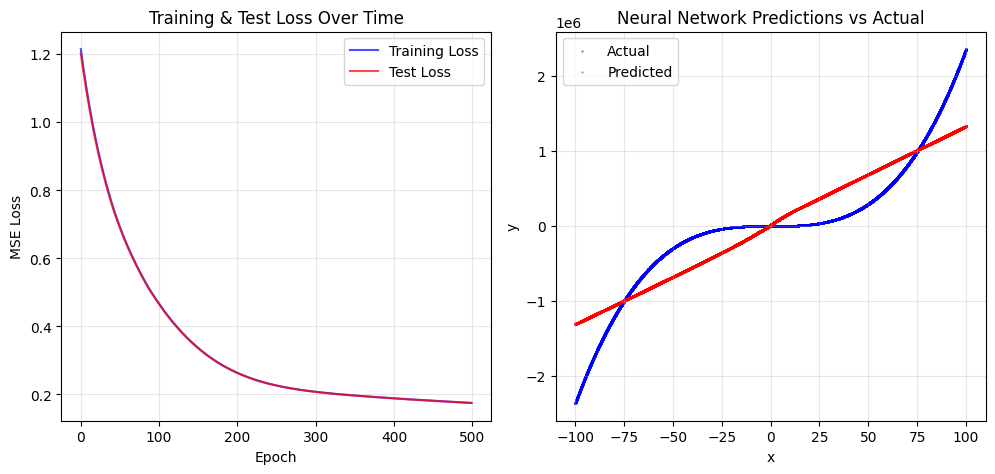

In [12]:
# Plot training progress
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Test Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Get final predictions for visualization
W1, b1, W2, b2, W3, b3 = weights
_, _, _, _, Y_pred_scaled = forward_pass(X_test_scaled, W1, b1, W2, b2, W3, b3)

# Inverse transform to original scale
Y_test_orig = scaler_Y.inverse_transform(Y_test_scaled)
Y_pred_orig = scaler_Y.inverse_transform(Y_pred_scaled)
X_test_orig = scaler_X.inverse_transform(X_test_scaled)

# Predictions vs Actual
plt.subplot(1, 3, 2)
plt.scatter(X_test_orig, Y_test_orig, s=1, alpha=0.3, label='Actual', color='blue')
plt.scatter(X_test_orig, Y_pred_orig, s=1, alpha=0.3, label='Predicted', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Network Predictions vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plot
# plt.subplot(1, 3, 3)
# residuals = Y_test_orig.flatten() - Y_pred_orig.flatten()
# plt.scatter(X_test_orig, residuals, s=1, alpha=0.3, color='green')
# plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
# plt.xlabel('x')
# plt.ylabel('Residuals (Actual - Predicted)')
# plt.title('Residual Analysis')
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Prediction Testing

In [13]:

x_test_value = 90.2
x_new = np.array([[x_test_value]])
x_new_scaled = scaler_X.transform(x_new)

_, _, _, _, y_pred_scaled = forward_pass(x_new_scaled, W1, b1, W2, b2, W3, b3)
y_pred = scaler_Y.inverse_transform(y_pred_scaled)

if poly_type == 0:
    _, b, c, d = coefficients
    y_true = b * x_test_value**2 + c * x_test_value + d

elif poly_type == 1:
    a, b, c, d = coefficients
    y_true = a * x_test_value**3 + b * x_test_value**2 + c * x_test_value + d

elif poly_type == 2:
    a, b, c, d, e = coefficients
    y_true = a * x_test_value**4 + b * x_test_value**3 + c * x_test_value**2 + d * x_test_value + e

elif poly_type == 3:
    a, b, c, d, freq, amp = coefficients
    y_true = a * x_test_value**3 + b * x_test_value**2 + c * x_test_value + d + amp * np.sin(freq * x_test_value)

else:
    a, b, c, d, inv_coeff = coefficients
    y_true = a * x_test_value**3 + b * x_test_value**2 + c * x_test_value + d + inv_coeff / (x_test_value + np.sign(x_test_value) * 0.1)

print("\n" + "="*60)
print("PREDICTION RESULTS FOR x = 90.2")
print("="*60)
print(f"Neural Network Prediction: {y_pred[0][0]:,.2f}")
print(f"Ground Truth (formula):    {y_true:,.2f}")
print(f"Absolute Error:            {abs(y_pred[0][0] - y_true):,.2f}")
print(f"Relative Error:            {abs(y_pred[0][0] - y_true)/abs(y_true)*100:.3f}%")




PREDICTION RESULTS FOR x = 90.2
Neural Network Prediction: 1,207,359.47
Ground Truth (formula):    1,732,312.09
Absolute Error:            524,952.62
Relative Error:            30.304%


## Final Performance Metrics

In [14]:
# Calculate final performance metrics
final_train_loss = train_losses[-1] if train_losses else float('inf')
final_test_loss = test_losses[-1] if test_losses else float('inf')

# Calculate R² score
y_test_mean = np.mean(Y_test_orig)
ss_res = np.sum((Y_test_orig - Y_pred_orig) ** 2)
ss_tot = np.sum((Y_test_orig - y_test_mean) ** 2)
r2_score = 1 - (ss_res / ss_tot)

print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"Final Training Loss: {final_train_loss:.6f}")
print(f"Final Test Loss:     {final_test_loss:.6f}")
print(f"R² Score:           {r2_score:.4f}")
print(f"Total Epochs Run:   {len(train_losses)}")


FINAL PERFORMANCE SUMMARY
Final Training Loss: 0.175295
Final Test Loss:     0.174865
R² Score:           0.8258
Total Epochs Run:   500
